In [1244]:
import pandas as pd
import tensorflow as tf
import numpy as np
import math
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from keras import models
from keras import layers
from keras import regularizers
import matplotlib.pyplot as plt
from keras import optimizers
from numpy.random import seed
from numpy import array
from numpy import argmax
from keras import metrics
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers

In [1245]:
file_path_assignment = os.path.join("data", "assignment_ds.csv")
file_path_test = os.path.join("data", "test_ds.csv")
file_path_sample = os.path.join("data", "sample_submission.csv")


First we put a seed so that we can have a consistent result (it doesn't change on every iteration).
Then we read the csv file.

In [1246]:
seed(10)
dataf_assigment = pd.read_csv(file_path_assignment)
dataf_assigment.head()

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3453,0.000621,0.0773,17.08,Red,M,0
1,12098,689.000000,7.0100,0.02,Blue-white,A,3
2,2731,0.000437,0.0856,18.09,Red,M,0
3,37800,202900.000000,6.8600,-4.56,Blue,O,3
4,8570,0.000810,0.0097,14.20,Blue white,A,2


# Dataframe cleaning

The first thing we do is check if there are any null values on the data.


In [1247]:
null_columns=dataf_assigment.columns[dataf_assigment.isnull().any()] #Returns if there is any null value on the columns
dataf_assigment[null_columns].isnull().sum()  # We can see how many null values are in the columns
print(dataf_assigment[dataf_assigment.isnull().any(axis=1)][null_columns].head()) # Prints the position of the null value. As we can see, there is no null value in the dataframe

Empty DataFrame
Columns: []
Index: []


# Colors cleaning



Then we check the columns with categorical values, in this case we have 'Color' and 'Spectral_Class'.


With this command we can see the values that appear at least once in the selected column. In this case are the values that are present on the column 'Color'.

In [1248]:
dataf_assigment['Color'].unique()

array(['Red', 'Blue-white', 'Blue', 'Blue white', 'Whitish', 'White',
       'Blue White', 'yellowish', 'white', 'yellow-white',
       'Yellowish White', 'Orange', 'White-Yellow', 'Pale yellow orange',
       'Orange-Red', 'Blue-White', 'Yellowish'], dtype=object)

As we can see, there are colors that are the same but with different name, so they don't match as the same color.

The next thing to do is to change the values of the colors so that they could tbe generic. In this case we look for pure colors, not a mix.

In [1249]:

dataf_assigment['Color'] = dataf_assigment['Color'].map({'Blue-white':'Blue', 'Blue white':'Blue', 'Blue-White':'Blue', 'Blue White':'Blue', 'Blue':'Blue',
                             'Whitish':'White', 'white':'White','White':'White',
                             'yellowish':'Yellow', 'yellow-white':'Yellow', 'Yellowish White':'Yellow', 'White-Yellow':'Yellow', 'Yellowish':'Yellow','Yellow':'Yellow',
                             'Pale yellow orange':'Orange','Orange':'Orange',
                             'Orange-Red':'Red','Red':'Red'})

In [1250]:
dataf_assigment['Color'].unique()

array(['Red', 'Blue', 'White', 'Yellow', 'Orange'], dtype=object)

Once the process is done, we get only generic colors in the column and we can classify them with numbers.

Another categorial column we have is the 'Spectral Class'

In [1251]:
dataf_assigment['Spectral_Class'].unique()

array(['M', 'A', 'O', 'B', 'K', 'F', 'G'], dtype=object)

In [1252]:
# Now we have to give the colors a value
dataf_assigment['Color'] = dataf_assigment['Color'].map({'Blue':1,
                             'White':2,
                             'Yellow':3,
                             'Orange':4,
                             'Red':5})
#Also we have to give a value to the spectral_class
dataf_assigment['Spectral_Class'] = dataf_assigment['Spectral_Class'].map({'M':1,
                             'B':2,
                             'O':3,
                             'K':4,
                             'F':5,
                             'A':6,
                             'G':7})
dataf_assigment.head()

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3453,0.000621,0.0773,17.08,5,1,0
1,12098,689.000000,7.0100,0.02,1,6,3
2,2731,0.000437,0.0856,18.09,5,1,0
3,37800,202900.000000,6.8600,-4.56,1,3,3
4,8570,0.000810,0.0097,14.20,1,6,2


In [1253]:
# shuffle dataset
dataf_assigment = dataf_assigment.sample(frac=1)

# get inputs - outputs
inputs = dataf_assigment[['Temperature','L','R','A_M','Color','Spectral_Class']]
target = dataf_assigment[['Type']]

Normalize data

In [1254]:
# scale input data
x = inputs.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
inputs = pd.DataFrame(x_scaled)
inputs[0:10]

,0,1,2,3,4,5
0,0.042984,1.448047e-01,0.023090,0.160725,1.0,0.000000
1,0.043772,1.483365e-01,0.576852,0.034709,1.0,0.000000
2,0.703108,1.976643e-02,0.003280,0.244841,0.0,0.166667
3,0.973726,2.401639e-01,0.005436,0.225766,0.0,0.333333
4,0.028980,4.944550e-10,0.000075,0.891807,1.0,0.000000
5,0.017919,6.121824e-10,0.000046,0.773296,1.0,0.000000
6,0.040750,3.178640e-01,0.780086,0.078799,1.0,0.000000
7,0.039227,6.945916e-10,0.000093,0.902439,1.0,0.000000
8,0.017367,3.767276e-10,0.000045,0.916823,1.0,0.000000
9,0.020809,4.202868e-10,0.000040,0.938399,1.0,0.000000


In [1255]:
#Hot enconde outputs
target.head()

,Type
59,4
5,5
20,3
198,3
52,0


In [1256]:
#integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(target)

# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
target = pd.DataFrame(onehot_encoded)

target.head()

D:\.Programas\anaconda\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


,0,1,2,3,4,5
0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0


In [1257]:

# define training dataset size
ds_size = inputs.shape[0]
train_size_percentage = .7
test_size_percentage = .2

training_size = int(ds_size * train_size_percentage)
test_size = int(ds_size * test_size_percentage)

# get training data
input_training = inputs[:training_size]
target_training = target[:training_size]

# get test data
input_test = inputs[training_size:(training_size + test_size)]
target_test = target[training_size:(training_size + test_size)]

# get validation data
input_validation = inputs[(training_size + test_size):]
target_validation = target[(training_size + test_size):]

# used during training
print('Training DS size:', input_training.shape[0])
print('Test DS size:', input_test.shape[0])

# used during validation
print('Validation DS size', input_validation.shape[0])

Training DS size: 140
Test DS size: 40
Validation DS size 20


In [1258]:
print('inputs:')
print(inputs[:10])
print('target')
target[:10]

inputs:
          0             1         2         3    4         5
0  0.042984  1.448047e-01  0.023090  0.160725  1.0  0.000000
1  0.043772  1.483365e-01  0.576852  0.034709  1.0  0.000000
2  0.703108  1.976643e-02  0.003280  0.244841  0.0  0.166667
3  0.973726  2.401639e-01  0.005436  0.225766  0.0  0.333333
4  0.028980  4.944550e-10  0.000075  0.891807  1.0  0.000000
5  0.017919  6.121824e-10  0.000046  0.773296  1.0  0.000000
6  0.040750  3.178640e-01  0.780086  0.078799  1.0  0.000000
7  0.039227  6.945916e-10  0.000093  0.902439  1.0  0.000000
8  0.017367  3.767276e-10  0.000045  0.916823  1.0  0.000000
9  0.020809  4.202868e-10  0.000040  0.938399  1.0  0.000000
target


,0,1,2,3,4,5
0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0
5,0.0,1.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,1.0
7,1.0,0.0,0.0,0.0,0.0,0.0
8,1.0,0.0,0.0,0.0,0.0,0.0
9,1.0,0.0,0.0,0.0,0.0,0.0



Train Neural Network 

Define Neural Network Architecture.

*   For this part there is an input shape of 6 because there are 6 columns with values that are the inputs.
*   In this Architecture there a 3 hidden layers the first one with 32 neourons, a second with 8 neourons and a third one with 8 neourons all using sigmoid function as activation function.
*   And ther 6 different outputs that represent the values that a star type represents. (0.Red Dwarf 1.Brown Dwarf 2.White Dwarf 3.Main Sequence 4.Super Giants 5.Hyper Giants ).e

In [1269]:
# neural network
model = models.Sequential()

# input layer
model.add(layers.Dense(32, activation='relu', input_shape=(6,)))

# hidden layers
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(8, activation='relu'))

# output layers
model.add(layers.Dense(6, activation='sigmoid'))
    
rmsprop = optimizers.RMSprop(learning_rate=0.01)
#learning_rate changed from 0.1 to 0.01
model.compile(optimizer=rmsprop, loss='mse', metrics=[metrics.categorical_accuracy])

In [1270]:
num_epochs = 250
batch_size = 64

history = model.fit(input_training, target_training,
                            validation_data=(input_test, target_test),
                            epochs=num_epochs, batch_size=batch_size, verbose=1)

Epoch 1/250
3/3 [==============================] - 0s 46ms/step - loss: 0.2444 - categorical_accuracy: 0.2714 - val_loss: 0.2137 - val_categorical_accuracy: 0.2250
Epoch 2/250
3/3 [==============================] - 0s 9ms/step - loss: 0.2007 - categorical_accuracy: 0.3286 - val_loss: 0.1745 - val_categorical_accuracy: 0.1750
Epoch 3/250
3/3 [==============================] - 0s 9ms/step - loss: 0.1591 - categorical_accuracy: 0.3286 - val_loss: 0.1523 - val_categorical_accuracy: 0.2000
Epoch 4/250
3/3 [==============================] - 0s 9ms/step - loss: 0.1359 - categorical_accuracy: 0.3429 - val_loss: 0.1389 - val_categorical_accuracy: 0.2000
Epoch 5/250
3/3 [==============================] - 0s 8ms/step - loss: 0.1255 - categorical_accuracy: 0.3500 - val_loss: 0.1342 - val_categorical_accuracy: 0.2500
Epoch 6/250
3/3 [==============================] - 0s 9ms/step - loss: 0.1200 - categorical_accuracy: 0.4357 - val_loss: 0.1284 - val_categorical_accuracy: 0.3500
Epoch 7/250
3/3 [====

Epoch 51/250
3/3 [==============================] - 0s 8ms/step - loss: 0.0367 - categorical_accuracy: 0.8857 - val_loss: 0.0486 - val_categorical_accuracy: 0.7500
Epoch 52/250
3/3 [==============================] - 0s 9ms/step - loss: 0.0361 - categorical_accuracy: 0.8429 - val_loss: 0.0340 - val_categorical_accuracy: 0.8500
Epoch 53/250
3/3 [==============================] - 0s 9ms/step - loss: 0.0307 - categorical_accuracy: 0.9214 - val_loss: 0.0300 - val_categorical_accuracy: 0.9000
Epoch 54/250
3/3 [==============================] - 0s 8ms/step - loss: 0.0273 - categorical_accuracy: 0.9357 - val_loss: 0.0259 - val_categorical_accuracy: 0.9750
Epoch 55/250
3/3 [==============================] - 0s 9ms/step - loss: 0.0300 - categorical_accuracy: 0.8714 - val_loss: 0.0388 - val_categorical_accuracy: 0.8750
Epoch 56/250
3/3 [==============================] - 0s 9ms/step - loss: 0.0366 - categorical_accuracy: 0.8714 - val_loss: 0.0320 - val_categorical_accuracy: 0.8750
Epoch 57/250
3/3

Epoch 101/250
3/3 [==============================] - 0s 8ms/step - loss: 0.0147 - categorical_accuracy: 0.9500 - val_loss: 0.0073 - val_categorical_accuracy: 1.0000
Epoch 102/250
3/3 [==============================] - 0s 9ms/step - loss: 0.0065 - categorical_accuracy: 0.9929 - val_loss: 0.0073 - val_categorical_accuracy: 1.0000
Epoch 103/250
3/3 [==============================] - 0s 8ms/step - loss: 0.0117 - categorical_accuracy: 0.9786 - val_loss: 0.0157 - val_categorical_accuracy: 0.9250
Epoch 104/250
3/3 [==============================] - 0s 8ms/step - loss: 0.0167 - categorical_accuracy: 0.9357 - val_loss: 0.0125 - val_categorical_accuracy: 0.9750
Epoch 105/250
3/3 [==============================] - 0s 9ms/step - loss: 0.0136 - categorical_accuracy: 0.9429 - val_loss: 0.0314 - val_categorical_accuracy: 0.8750
Epoch 106/250
3/3 [==============================] - 0s 9ms/step - loss: 0.0193 - categorical_accuracy: 0.9286 - val_loss: 0.0052 - val_categorical_accuracy: 1.0000
Epoch 107/

Epoch 151/250
3/3 [==============================] - 0s 9ms/step - loss: 0.0107 - categorical_accuracy: 0.9500 - val_loss: 0.0024 - val_categorical_accuracy: 1.0000
Epoch 152/250
3/3 [==============================] - 0s 8ms/step - loss: 0.0032 - categorical_accuracy: 1.0000 - val_loss: 0.0208 - val_categorical_accuracy: 0.9250
Epoch 153/250
3/3 [==============================] - 0s 8ms/step - loss: 0.0083 - categorical_accuracy: 0.9929 - val_loss: 0.0017 - val_categorical_accuracy: 1.0000
Epoch 154/250
3/3 [==============================] - 0s 8ms/step - loss: 0.0019 - categorical_accuracy: 1.0000 - val_loss: 0.0053 - val_categorical_accuracy: 0.9750
Epoch 155/250
3/3 [==============================] - 0s 8ms/step - loss: 0.0022 - categorical_accuracy: 1.0000 - val_loss: 0.0019 - val_categorical_accuracy: 1.0000
Epoch 156/250
3/3 [==============================] - 0s 8ms/step - loss: 0.0023 - categorical_accuracy: 1.0000 - val_loss: 0.0017 - val_categorical_accuracy: 1.0000
Epoch 157/

3/3 [==============================] - 0s 9ms/step - loss: 0.0012 - categorical_accuracy: 1.0000 - val_loss: 5.0764e-04 - val_categorical_accuracy: 1.0000
Epoch 201/250
3/3 [==============================] - 0s 9ms/step - loss: 8.5202e-04 - categorical_accuracy: 1.0000 - val_loss: 7.3814e-04 - val_categorical_accuracy: 1.0000
Epoch 202/250
3/3 [==============================] - 0s 8ms/step - loss: 0.0014 - categorical_accuracy: 1.0000 - val_loss: 3.9748e-04 - val_categorical_accuracy: 1.0000
Epoch 203/250
3/3 [==============================] - 0s 9ms/step - loss: 0.0135 - categorical_accuracy: 0.9429 - val_loss: 0.0150 - val_categorical_accuracy: 0.9500
Epoch 204/250
3/3 [==============================] - 0s 9ms/step - loss: 0.0092 - categorical_accuracy: 0.9714 - val_loss: 0.0131 - val_categorical_accuracy: 0.9750
Epoch 205/250
3/3 [==============================] - 0s 8ms/step - loss: 0.0081 - categorical_accuracy: 0.9857 - val_loss: 0.0015 - val_categorical_accuracy: 1.0000
Epoch 20

Epoch 249/250
3/3 [==============================] - 0s 9ms/step - loss: 4.7331e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0016 - val_categorical_accuracy: 1.0000
Epoch 250/250
3/3 [==============================] - 0s 11ms/step - loss: 6.0479e-04 - categorical_accuracy: 1.0000 - val_loss: 7.1570e-04 - val_categorical_accuracy: 1.0000


In [1274]:
epochs = range(1, num_epochs+1)

# during training
loss = history.history['loss']
accuracy = history.history['categorical_accuracy']

# outside training
val_loss = history.history['val_loss']
val_accuracy = history.history['val_categorical_accuracy']

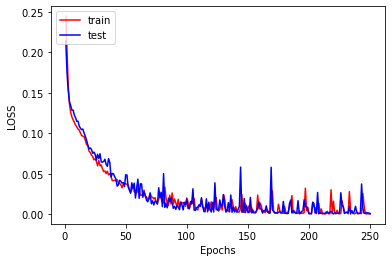

In [1275]:
# plot loss
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.xlabel('Epochs')
plt.ylabel('LOSS')
plt.legend(['train', 'test'], loc='upper left')

plt.show()
#AUMENTAR NUM EPOCHS

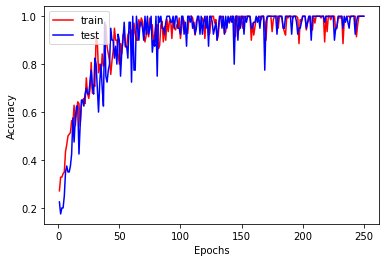

In [1276]:
# plot accuracy
plt.plot(epochs, accuracy, 'r')
plt.plot(epochs, val_accuracy, 'b')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Validate

In [1186]:
#predict
predictions_targets = model.predict(input_validation)
predicted = label_encoder.inverse_transform(predictions_targets.argmax(1))

In [ ]:
# target
targets_val = label_encoder.inverse_transform(np.array(target_validation.values).argmax(1))

In [1158]:
# compare them
df = pd.DataFrame({'target':targets_val, 'predicted': predicted})
df

,target,predicted
0,5,5
1,1,1
2,0,1
3,3,3
4,1,1
5,5,5
6,5,5
7,4,4
8,0,1
9,4,4


applying to the test

In [1160]:
dataf_test = pd.read_csv(file_path_test)
dataf_test['Color'] = dataf_test['Color'].map({'Blue-white':'Blue', 'Blue white':'Blue', 'Blue-White':'Blue', 'Blue White':'Blue', 'Blue':'Blue',
                             'Whitish':'White', 'white':'White','White':'White',
                             'yellowish':'Yellow', 'yellow-white':'Yellow', 'Yellowish White':'Yellow', 'White-Yellow':'Yellow', 'Yellowish':'Yellow','Yellow':'Yellow',
                             'Pale yellow orange':'Orange','Orange':'Orange',
                             'Orange-Red':'Red','Red':'Red'})
dataf_test['Color'] = dataf_test['Color'].map({'Blue':1,
                             'White':2,
                             'Yellow':3,
                             'Orange':4,
                             'Red':5})
#Also we have to give a value to the spectral_class
dataf_test['Spectral_Class'] = dataf_test['Spectral_Class'].map({'M':1,
                             'B':2,
                             'O':3,
                             'K':4,
                             'F':5,
                             'A':6,
                             'G':7})
dataf_test.head()

,Temperature,L,R,A_M,Color,Spectral_Class
0,21020,0.00150,0.0112,11.52,1,2
1,2935,0.00087,0.0932,16.88,5,1
2,16390,1278.00000,5.6800,-3.32,1,2
3,3628,0.00550,0.3930,10.48,5,1
4,3496,0.00125,0.3360,14.94,5,1


In [1161]:
# get inputs
inputs = dataf_test[['Temperature','L','R','A_M','Color','Spectral_Class']]

# scale input data
x = inputs.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
inputs = pd.DataFrame(x_scaled)
inputs[0:10]

predicted_classes = model.predict(inputs)
predicted_classes = np.argmax(np.round(predicted_classes), axis = 1)
predicted_classes

array([2, 0, 3, 1, 0, 1, 3, 5, 5, 2, 4, 2, 3, 0, 0, 4, 2, 5, 0, 4, 0, 5,
       4, 4, 0, 1, 0, 5, 3, 4, 3, 3, 0, 5, 0, 1, 4, 0, 0], dtype=int64)